
# Retail Demand Forecasting – Global Model by StockCode

This notebook:
- Loads the Online Retail dataset (2010–2011)
- Aggregates to **daily sales per StockCode**
- Builds **time-series features** (calendar, lags, rolling means)
- Trains **one global RandomForest model** for all StockCodes
- Computes **weekly, monthly, yearly baselines** per StockCode
- Saves artifacts for Flask backend:
  - `model.pkl`
  - `stockcode_mapping.pkl`
  - `stock_baselines.pkl`
  - `daily_history.csv`


In [1]:

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

from datetime import timedelta
import os


## 1. Load & inspect data

In [2]:

#vscode ran it

In [3]:


file_path = "data/Online-Retail.xlsx"

df = pd.read_excel(file_path)
df["StockCode"] = df["StockCode"].astype(str).str.strip()

print(df["StockCode"].head())
print(df["StockCode"].dtype)

0    85123A
1     71053
2    84406B
3    84029G
4    84029E
Name: StockCode, dtype: object
object


## 2. Basic cleaning & total sales

In [4]:

df = df.copy()

# Keep only positive quantities (drop returns/cancellations for now)
df = df[df["Quantity"] > 0]

# Drop rows with missing critical fields
df = df.dropna(subset=["StockCode", "InvoiceDate", "UnitPrice"])

# Compute total sales value for each line item
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Ensure proper datetime type
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## 3. Aggregate to daily sales per StockCode

In [5]:

daily = (
    df.groupby([df["InvoiceDate"].dt.date, "StockCode"])["TotalPrice"]
      .sum()
      .reset_index()
      .rename(columns={"InvoiceDate": "Date", "TotalPrice": "DailySales"})
)

daily["Date"] = pd.to_datetime(daily["Date"])
daily = daily.sort_values(["StockCode", "Date"]).reset_index(drop=True)

print(daily.shape)
daily.head()


(276843, 3)


,Date,StockCode,DailySales
0,2010-12-01,10002,51.00
1,2010-12-02,10002,0.85
2,2010-12-03,10002,12.47
3,2010-12-05,10002,0.85
4,2010-12-06,10002,22.06


## 4. Add calendar / seasonality features

In [6]:

daily["year"] = daily["Date"].dt.year
daily["month"] = daily["Date"].dt.month
daily["day_of_week"] = daily["Date"].dt.dayofweek
daily["week_of_year"] = daily["Date"].dt.isocalendar().week.astype(int)

daily.head()


,Date,StockCode,DailySales,year,month,day_of_week,week_of_year
0,2010-12-01,10002,51.00,2010,12,2,48
1,2010-12-02,10002,0.85,2010,12,3,48
2,2010-12-03,10002,12.47,2010,12,4,48
3,2010-12-05,10002,0.85,2010,12,6,48
4,2010-12-06,10002,22.06,2010,12,0,49


## 5. Lag & rolling features per StockCode

In [7]:

daily = daily.sort_values(["StockCode", "Date"]).reset_index(drop=True)
group = daily.groupby("StockCode")

# Lag features
daily["lag_1"] = group["DailySales"].shift(1)
daily["lag_7"] = group["DailySales"].shift(7)

# Rolling mean features
daily["roll_mean_7"] = (
    group["DailySales"]
    .rolling(window=7, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

daily["roll_mean_28"] = (
    group["DailySales"]
    .rolling(window=28, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

daily.head(15)


,Date,StockCode,DailySales,year,month,day_of_week,week_of_year,lag_1,lag_7,roll_mean_7,roll_mean_28
0,2010-12-01,10002,51.00,2010,12,2,48,NaN,NaN,51.000000,51.000000
1,2010-12-02,10002,0.85,2010,12,3,48,51.00,NaN,25.925000,25.925000
2,2010-12-03,10002,12.47,2010,12,4,48,0.85,NaN,21.440000,21.440000
3,2010-12-05,10002,0.85,2010,12,6,48,12.47,NaN,16.292500,16.292500
4,2010-12-06,10002,22.06,2010,12,0,49,0.85,NaN,17.446000,17.446000
5,2010-12-07,10002,13.28,2010,12,1,49,22.06,NaN,16.751667,16.751667
6,2010-12-08,10002,11.86,2010,12,2,49,13.28,NaN,16.052857,16.052857
7,2010-12-09,10002,39.02,2010,12,3,49,11.86,51.00,14.341429,18.923750
8,2010-12-10,10002,40.80,2010,12,4,49,39.02,0.85,20.048571,21.354444
9,2010-12-13,10002,25.38,2010,12,0,50,40.80,12.47,21.892857,21.757000


## 6. Filter rows for modelling

In [8]:

# Require at least lag_7 to exist (so we have some history)
feature_cols = [
    "year", "month", "day_of_week", "week_of_year",
    "lag_1", "lag_7", "roll_mean_7", "roll_mean_28"
]

daily_model = daily.dropna(subset=["lag_7"]).reset_index(drop=True)
print(daily_model.shape)
daily_model.head()


(251695, 11)


,Date,StockCode,DailySales,year,month,day_of_week,week_of_year,lag_1,lag_7,roll_mean_7,roll_mean_28
0,2010-12-09,10002,39.02,2010,12,3,49,11.86,51.00,14.341429,18.923750
1,2010-12-10,10002,40.80,2010,12,4,49,39.02,0.85,20.048571,21.354444
2,2010-12-13,10002,25.38,2010,12,0,50,40.80,12.47,21.892857,21.757000
3,2010-12-14,10002,5.95,2010,12,1,50,25.38,0.85,22.621429,20.320000
4,2010-12-16,10002,4.25,2010,12,3,50,5.95,22.06,20.077143,18.980833


## 7. Encode StockCode and build feature matrix

In [9]:

# Map StockCode to integer ID
stockcodes = daily_model["StockCode"].unique()
stockcode_to_id = {code: idx for idx, code in enumerate(stockcodes)}
id_to_stockcode = {idx: code for code, idx in stockcode_to_id.items()}

daily_model["StockCode_id"] = daily_model["StockCode"].map(stockcode_to_id)

X_cols = feature_cols + ["StockCode_id"]
X = daily_model[X_cols]
y = daily_model["DailySales"]

X.head()


,year,month,day_of_week,week_of_year,lag_1,lag_7,roll_mean_7,roll_mean_28,StockCode_id
0,2010,12,3,49,11.86,51.00,14.341429,18.923750,0
1,2010,12,4,49,39.02,0.85,20.048571,21.354444,0
2,2010,12,0,50,40.80,12.47,21.892857,21.757000,0
3,2010,12,1,50,25.38,0.85,22.621429,20.320000,0
4,2010,12,3,50,5.95,22.06,20.077143,18.980833,0


## 8. Time-based train / test split

In [10]:

# Use 80% of timeline for training, last 20% for testing
cutoff_date = daily_model["Date"].quantile(0.8)

train_mask = daily_model["Date"] <= cutoff_date
test_mask = daily_model["Date"] > cutoff_date

X_train = X[train_mask]
y_train = y[train_mask]

X_test = X[test_mask]
y_test = y[test_mask]

print("Cutoff date:", cutoff_date)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Cutoff date: 2011-10-26 00:00:00
Train size: (202254, 9) Test size: (49441, 9)


## 9. Train global RandomForest model

In [11]:

model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)  # this returns MSE
rmse = mse ** 0.5                        # take the square root for RMSE
mae = mean_absolute_error(y_test, y_pred)

print(f"Global model RMSE: {rmse:.2f}")
print(f"Global model MAE:  {mae:.2f}")



Global model RMSE: 105.93
Global model MAE:  28.20


## 10. Build weekly, monthly, yearly baselines per StockCode

In [12]:

# Weekly totals
weekly = (
    daily.assign(
        week_start=daily["Date"] - pd.to_timedelta(daily["Date"].dt.dayofweek, unit="D")
    )
    .groupby(["StockCode", "week_start"])["DailySales"]
    .sum()
    .reset_index()
)

# Monthly totals
monthly = (
    daily.assign(
        year=daily["Date"].dt.year,
        month=daily["Date"].dt.month,
    )
    .groupby(["StockCode", "year", "month"])["DailySales"]
    .sum()
    .reset_index()
)

# Yearly totals
yearly = (
    daily.assign(year=daily["Date"].dt.year)
    .groupby(["StockCode", "year"])["DailySales"]
    .sum()
    .reset_index()
)

# Baseline windows
N_WEEKS = 8
N_MONTHS = 6

weekly_baselines = {}
for code, grp in weekly.groupby("StockCode"):
    last_weeks = grp.sort_values("week_start").tail(N_WEEKS)
    if len(last_weeks) == 0:
        continue
    weekly_baselines[code] = float(last_weeks["DailySales"].mean())

monthly_baselines = {}
for code, grp in monthly.groupby("StockCode"):
    last_months = grp.sort_values(["year", "month"]).tail(N_MONTHS)
    if len(last_months) == 0:
        continue
    monthly_baselines[code] = float(last_months["DailySales"].mean())

yearly_baselines = {}
for code, grp in yearly.groupby("StockCode"):
    if len(grp) == 0:
        continue
    yearly_baselines[code] = float(grp["DailySales"].mean())

# Combine into a single dict
stock_baselines = {}
all_codes = daily["StockCode"].unique()

for code in all_codes:
    stock_baselines[code] = {
        "avg_week_sales": weekly_baselines.get(code),
        "avg_month_sales": monthly_baselines.get(code),
        "avg_year_sales": yearly_baselines.get(code),
    }

len(stock_baselines), list(stock_baselines.items())[:3]


(3941,
 [('10002',
   {'avg_week_sales': 27.36875,
    'avg_month_sales': 151.978,
    'avg_year_sales': 379.945}),
  ('10080',
   {'avg_week_sales': 5.89875,
    'avg_month_sales': 19.565,
    'avg_year_sales': 119.08999999999999}),
  ('10120',
   {'avg_week_sales': 1.8900000000000001,
    'avg_month_sales': 4.025,
    'avg_year_sales': 20.265})])

## 11. Evaluate model on 3 example StockCodes

In [13]:

test_codes = ["21080", "20727", "21731"]  # adjust based on your data


for code in test_codes:
    mask = test_mask & (daily_model["StockCode"] == code)
    if mask.sum() == 0:
        print(f"StockCode {code}: no rows in test set.\n")
        continue
    
    X_code = X[mask]
    y_code = y[mask]
    y_code_pred = model.predict(X_code)
    
    mse_code = mean_squared_error(y_code, y_code_pred)   # no 'squared' arg
    rmse_code = mse_code ** 0.5                          # manual sqrt
    mae_code = mean_absolute_error(y_code, y_code_pred)
    
    print(f"StockCode {code}:")
    print(f"  Test samples: {mask.sum()}")
    print(f"  RMSE: {rmse_code:.2f}")
    print(f"  MAE:  {mae_code:.2f}\n")

StockCode 21080:
  Test samples: 36
  RMSE: 28.85
  MAE:  21.45

StockCode 20727:
  Test samples: 38
  RMSE: 38.09
  MAE:  29.19

StockCode 21731:
  Test samples: 38
  RMSE: 82.69
  MAE:  57.86



In [14]:
codes_with_rows = (
    daily_model["StockCode"]
    .value_counts()
    .head(50)
)

print(codes_with_rows)


StockCode
85123A    298
85099B    294
22423     294
84879     293
21212     291
20725     291
22457     290
22960     288
22666     287
22197     287
47566     287
20728     286
21080     285
20727     285
22384     285
82482     285
22727     283
22178     283
21931     282
22697     282
22386     281
22077     281
20726     280
22383     280
22961     279
20724     279
22411     279
85099C    278
22382     278
22355     278
22699     276
20914     275
21754     274
21790     274
22629     274
22728     272
22630     272
21929     272
21175     271
20712     270
21977     270
22558     269
20719     268
84946     268
POST      268
21034     267
21232     265
22659     263
21731     263
22139     263
Name: count, dtype: int64


In [15]:
for code in ["21731", "85099B", "22960"]:
    subset = daily_model[daily_model["StockCode"] == code]
    print(code, "rows in daily_model:", subset.shape[0])


21731 rows in daily_model: 263
85099B rows in daily_model: 294
22960 rows in daily_model: 288


## 12. Helper functions for future Flask integration

In [16]:

def build_feature_row_for_date(stock_code, target_date, history_df, daily_model_df):
    """
    Build a single feature row for a given StockCode and target date.

    This uses the latest available lag and rolling values from daily_model_df
    as a simplified approximation for future forecasts.
    """
    if stock_code not in stockcode_to_id:
        raise ValueError(f"Unknown StockCode: {stock_code}")
    
    # Ensure datetime
    target_date = pd.to_datetime(target_date)
    
    # Calendar features
    year = target_date.year
    month = target_date.month
    day_of_week = target_date.dayofweek
    week_of_year = int(target_date.isocalendar().week)
    
    # Latest row for this stock_code in daily_model_df
    hist_rows = daily_model_df[daily_model_df["StockCode"] == stock_code].sort_values("Date")
    if hist_rows.empty:
        raise ValueError(f"No history for StockCode: {stock_code}")
    
    latest_row = hist_rows.iloc[-1]
    
    feature_row = {
        "year": year,
        "month": month,
        "day_of_week": day_of_week,
        "week_of_year": week_of_year,
        "lag_1": latest_row["lag_1"],
        "lag_7": latest_row["lag_7"],
        "roll_mean_7": latest_row["roll_mean_7"],
        "roll_mean_28": latest_row["roll_mean_28"],
        "StockCode_id": stockcode_to_id[stock_code],
    }
    
    return pd.DataFrame([feature_row])


In [17]:
import pandas as pd

def forecast_next_days_(stock_code, n_days, model, stockcode_to_id, daily, daily_model):
    """
    Naive forecast helper:
    - Takes the last known feature row for a given StockCode
    - Uses the trained model to predict once
    - Repeats that prediction for the next n_days
    - Returns a list of (future_date, predicted_value)
    """
    # 1) Check that this stock exists in the model mapping
    if stockcode_to_id is not None and stock_code not in stockcode_to_id:
        raise ValueError(f"Unknown StockCode in model: {stock_code}")

    # 2) Get history for this stock from the feature dataset
    hist = daily_model[daily_model["StockCode"] == stock_code].sort_values("Date")
    if hist.empty:
        raise ValueError(f"No history found in daily_model for StockCode: {stock_code}")

    # 3) Use the last available row as "current state"
    last_row = hist.iloc[-1]

    # Features = everything except ID / date / target
    feature_cols = [c for c in daily_model.columns 
                    if c not in ["Date", "StockCode", "DailySales", "Sales", "Quantity"]]

    X_last = last_row[feature_cols].values.reshape(1, -1)

    # 4) Predict one-step value and reuse for horizon (simple baseline)
    y_pred = float(model.predict(X_last)[0])

    preds = []
    last_date = last_row["Date"]

    for i in range(1, n_days + 1):
        future_date = last_date + pd.Timedelta(days=i)
        preds.append((future_date, y_pred))

    return preds


In [18]:
import pandas as pd

def forecast_next_days_df(stock_code, n_days, model, stockcode_to_id, daily, daily_model):
    preds = forecast_next_days_(
        stock_code,
        n_days,
        model,
        stockcode_to_id,
        daily,
        daily_model
    )
    
    return pd.DataFrame({
        "Date": [d for d, _ in preds],
        "PredictedDailySales": [round(float(y), 2) for _, y in preds]
    })

# Example: 7-day forecast for one SKU
forecast_df = forecast_next_days_df(
    "85099B",
    7,
    model,
    stockcode_to_id,
    daily,
    daily_model
)

forecast_df



c:\Users\stern\GeorgeBrownAI\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


,Date,PredictedDailySales
0,2011-12-10,253.27
1,2011-12-11,253.27
2,2011-12-12,253.27
3,2011-12-13,253.27
4,2011-12-14,253.27
5,2011-12-15,253.27
6,2011-12-16,253.27



## 13. Visualize total predicted sales for selected StockCodes

Here we forecast the next 7 days for a few example StockCodes and plot the total predicted sales.


c:\Users\stern\GeorgeBrownAI\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\stern\GeorgeBrownAI\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\stern\GeorgeBrownAI\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


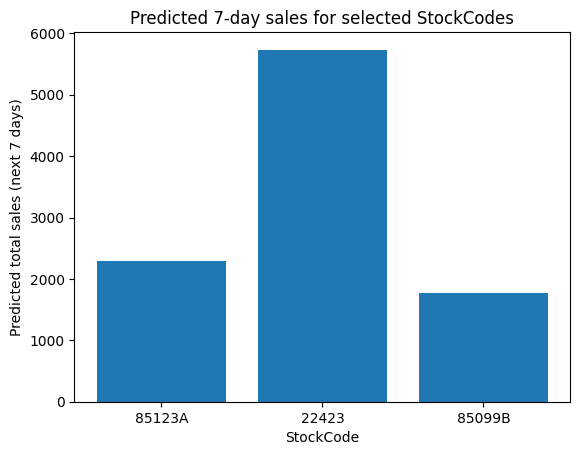

In [19]:

import matplotlib.pyplot as plt

# Select example StockCodes (ensure they exist in your data)
plot_codes = ["85123A", "22423", "85099B"]

results = []
for code in plot_codes:
    try:
        preds = forecast_next_days_(code, 7, model, stockcode_to_id, daily, daily_model)
        total_pred = sum(val for _, val in preds)
        results.append({"StockCode": code, "PredictedNext7DaysSales": total_pred})
    except ValueError as e:
        print(e)

pred_df = pd.DataFrame(results)

if not pred_df.empty:
    plt.figure()
    plt.bar(pred_df["StockCode"], pred_df["PredictedNext7DaysSales"])
    plt.xlabel("StockCode")
    plt.ylabel("Predicted total sales (next 7 days)")
    plt.title("Predicted 7-day sales for selected StockCodes")
    plt.show()
else:
    print("No valid StockCodes to plot. Check plot_codes list.")


## 14. Save artifacts for Flask backend

In [20]:

os.makedirs("artifacts", exist_ok=True)

# Save model
joblib.dump(model, "artifacts/model.pkl")

# Save StockCode mapping
joblib.dump(stockcode_to_id, "artifacts/stockcode_mapping.pkl")

# Save baselines (weekly, monthly, yearly)
joblib.dump(stock_baselines, "artifacts/stock_baselines.pkl")

# Save daily history for forecasting
daily.to_csv("artifacts/daily_history.csv", index=False)

print("Artifacts saved in ./artifacts")


Artifacts saved in ./artifacts
